<a href="https://colab.research.google.com/github/KevinFallon/fastai/blob/main/FastAI_Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
path = untar_data(URLs.PETS)

     |████████████████████████████████| 719 kB 1.7 MB/s 
     |████████████████████████████████| 451 kB 11.0 MB/s 
     |████████████████████████████████| 1.3 MB 45.9 MB/s 
     |████████████████████████████████| 5.5 MB 12.6 MB/s 
     |████████████████████████████████| 1.6 MB 52.9 MB/s 
     |████████████████████████████████| 212 kB 58.1 MB/s 
     |████████████████████████████████| 182 kB 57.1 MB/s 
     |████████████████████████████████| 115 kB 61.1 MB/s 
     |████████████████████████████████| 127 kB 55.0 MB/s 
     |████████████████████████████████| 7.6 MB 55.2 MB/s 
Mounted at /content/gdrive


In [3]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('annotations'),Path('images')]

In [4]:
(path/"images").ls()

(#7393) [Path('images/japanese_chin_8.jpg'),Path('images/Bengal_97.jpg'),Path('images/Bombay_29.jpg'),Path('images/Bengal_1.jpg'),Path('images/Siamese_162.jpg'),Path('images/Egyptian_Mau_129.jpg'),Path('images/leonberger_153.jpg'),Path('images/Bengal_95.jpg'),Path('images/Birman_199.jpg'),Path('images/pug_119.jpg')...]

In [5]:
fname = (path/"images").ls()[0]
print(fname)
re.findall(r'(.+)_\d+.jpg$', fname.name)

/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_8.jpg


['japanese_chin']

In [6]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 # The two lines after this are for "Presizing"
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

'''
Presizing is a way to do image augmentation that is designed to minimize data
destruction while maintaining good performance. We need images to have the same
dimensions so they can collate into tensors to be passed to the GPU. Additionally,
we want to minimize the number of distinct augmentation computations we pefrom. 


transform images into uniform sizes for more efficient processing on the GPU.

Presizing strategies:
1. Resize images to relatively "large" dimensions. Dimenions significantly larger
than the target training dimensions.
2. Compose all the common augmentation operations into one and perform combined
operation on the GPU only at the end of processing, rather than performing operations individually
and interpolating multiple times.
'''
dls = pets.dataloaders(path/'images')

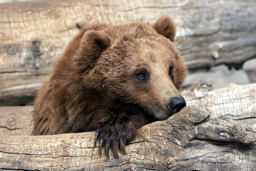

In [7]:
key = os.environ.get('AZURE_SEARCH_KEY', '0302a1f901a545f2986fcdd53310b214')
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
# print(ims)

from fastdownload import download_url
dest = Path.cwd()/'images'/'grizzly.jpg'
download_url(ims[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256, 256)

before
torch.Size([4, 3, 460, 460])
after
torch.Size([4, 3, 224, 224])


'\nIt has been found thatin practice using presizing significantly improves the\naccuracy of models, and often results in speedups too.\n'

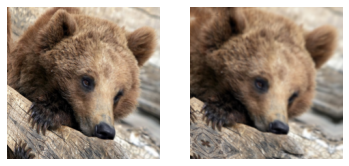

In [8]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_y=parent_label,
                    item_tfms=Resize(460),
)

dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=4)
dls1.train.get_idxs = lambda: Inf.ones
# x is independent variable, so a TensorImage
# y is dependent variable, so a 1 rank tensor of size `bs` representing possible
# categories.
x,y = dls1.valid.one_batch()
_, axs = subplots(1, 2)

x1 = TensorImage(x.clone())
print("before")
print(x1.size())
x1 = x1.affine_coord(sz=224)
print("after")
print(x1.size())
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.0)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
pipeline = Pipeline(tfms)
x = pipeline(x)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);
'''
It has been found thatin practice using presizing significantly improves the
accuracy of models, and often results in speedups too.
'''

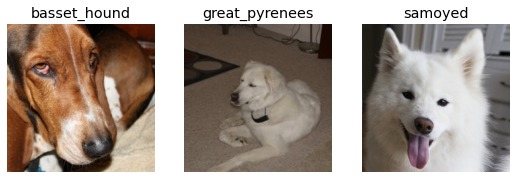

In [9]:
'''
its easy to make unnoticed mistakes while setting up the datablock so its important
to verify the labeled data appears to be correct.
'''
dls.show_batch(nrows=1, ncols=3)

In [10]:
# this is an example of which we forget to set the resize function. its useful
# to use the 'summary' method to check for mistakes.
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# purposely fails with an error describing non-consistent sizing of images
# pets1.summary(path/'images')

In [11]:
'''
it's important to train any model asap so we can some insight on how to best proceed and iterate
is the data good enough? maybe we already have a good enough model and dont need to spend
additional engineering time on new features
'''
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.432648,0.326566,0.107578,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.494615,0.276380,0.095399,01:17
1,0.321503,0.209628,0.069689,01:15


In [18]:
'''
cross-entropy loss is what the fastai library uses for image data as input
with a categorical output. fastai tries its best to choose an appropriate loss
function when its not supplied.
cross-entropy loss function has 2 benefits:
1. it works even when our dependent variable has more than two categories
2. it results in faster and more reliable training.


'''

x, y = dls.one_batch()
# batchsize is 64, so a len 64 list of targets 1-36 since we have 36 categories. 
print(y)
print(len(y))

# 
preds, _ = learn.get_preds(dl=[(x, y)])
# 37 probabilities between 0 and 1. The probability the first image is each of
# the possible categories.
print(preds[0])

# the sum of all the predictions adds up to 1.
print(len(preds[0]), preds[0].sum())


TensorCategory([10, 16, 28,  3, 31, 30, 34, 36, 11, 26, 19, 20, 22,  7, 24, 11, 28, 17,  6, 10, 16, 19, 13, 19,  1,  5, 36, 15,  7,  5, 35, 24, 24, 12, 12,  5, 31, 30,  6,  2, 21, 10, 22, 17, 10, 16,
                23, 13, 28, 30, 17, 28, 32, 25,  2,  1,  1,  6, 21, 33,  1, 33, 32, 35], device='cuda:0')
64


TensorBase([1.3839e-05, 6.1899e-07, 1.0388e-03, 2.8243e-05, 8.8935e-07, 1.3890e-06, 1.3796e-08, 5.2389e-07, 5.0391e-05, 1.4193e-06, 9.9880e-01, 5.6233e-07, 1.6069e-07, 5.9685e-08, 2.2289e-07,
            2.5144e-06, 7.3344e-07, 1.0905e-05, 2.7921e-06, 3.4624e-08, 2.0696e-06, 2.0717e-07, 1.2446e-07, 1.4243e-07, 2.6852e-07, 9.4039e-07, 1.3153e-05, 8.9994e-08, 1.6636e-07, 2.9490e-06,
            5.6055e-07, 7.4606e-07, 4.4503e-06, 1.3334e-06, 1.4268e-07, 2.5550e-06, 1.4003e-05])
37 TensorBase(1.0000)


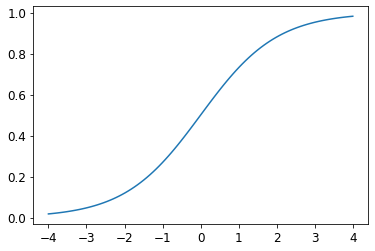

In [19]:
'''
Softmax activation function is used in the final layer to ensure the activations
are all between 0 and 1, and that they sum to 1.
Softmax is similar to the sigmoid function from earlier.
'''

plot_function(torch.sigmoid, min=-4, max=4)

In [20]:
torch.random.manual_seed(42)
acts = torch.randn( (6,2) )*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [29]:
'''
Activation functions
In an artificial neural network, the activation function of a neuron defines the
output of that neuron given a set of inputs. Biologically inspired by activity
in our brains, where different neurons fire, or are *activated*, by different
stimuli.

1 = firing
0 = not firing

but continuous - can be between 0 and 1.

There are many different types of activation functions.
- ReLu
- Sigmoid
- tanh 
'''

print((acts[:,0]-acts[:,1]))
(acts[:,0]-acts[:,1]).sigmoid()

'''
softmax is a multi-category equivalent of sigmoid - we have to use it any time
we have more than two categories and the probabilities of the categories must
add to 1. We often use it when there are 2 categories to be consistent.
'''
print(acts.size())
print(acts)
sm_acts = torch.softmax(acts, dim=1)
print(sm_acts)
'''
softmax takes an exponential which ensures all numbers are positive. it then
divides by the sum to ensure we are going to have a bunch of numbers that add up
to 1. additionally, if one of the numbers in our activations x is slightly
bigger than the others, the exponential will amplify this, which means that in
the softmax, that number will be closer to 1.

softmax function wants to pick one class among the others, so its ideal for
training a classifier when we know each picture has a definite label.

softmax is the first part of cross-entropy loss. the second part is log likelihood.
'''

'''
softmax is typically only used for the output layer, not any of the hidden layers.
'''

tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])
torch.Size([6, 2])
tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])
tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])


'\nsoftmax is typically only used for the output layer, not any of the hidden layers.\n'